# Swissroads Project: 02 - Data exploration  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.

## Aim of this notebook 

The goal of this jupyter notebook is to perform a quick data exploration on the swissroads data set. 
As a first step, we will plot a random subset of the raw data. Then, we will perform a Principal Components Analysis. The data for the the PCA, were produced by extracting the 2048 most important features in each picture, using Inception_v3 ConvNet from the tensorflow hub. 


## Data visualisation

First, let's display a subset of the pictures. 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os


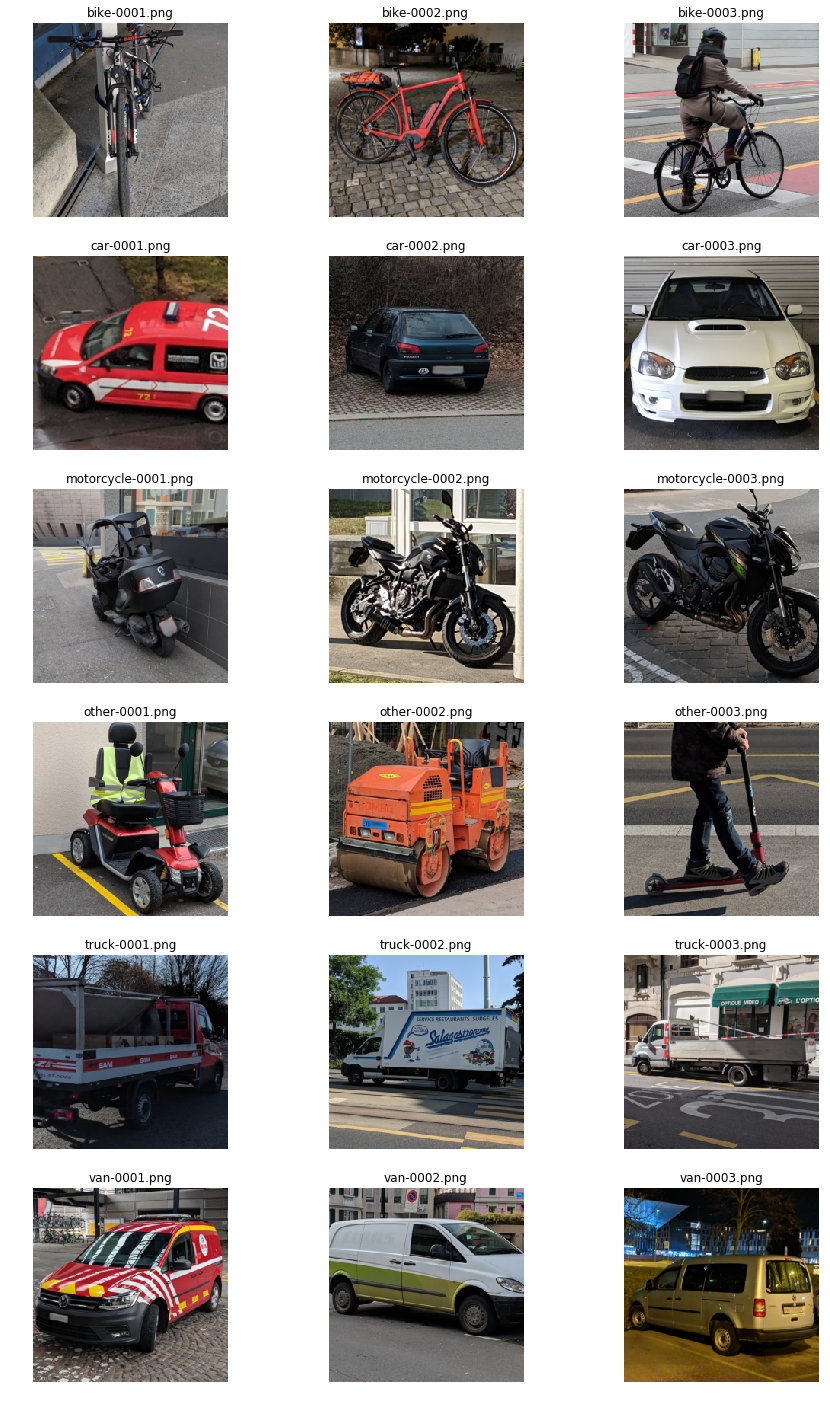

In [2]:
# loading  a few data
import PIL.Image as Image
%matplotlib inline
import matplotlib.pyplot as plt


# Load image
all_folders = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']
mypath = "swissroads/train"
onlyfiles = [f for f in os.listdir(mypath)]
#img = Image.open('swissroads/train/bike/bike-0001.png')
images= []
titles =[]

rows = 6
columns = 3
fig = plt.figure(figsize=(15, 25))
pos = 0
for folder in all_folders: 
    for file in [f for f in os.listdir(os.path.join(mypath, folder))][:3]:
        pos +=1
        img =Image.open(os.path.join(mypath, folder,file))
        fig.add_subplot(rows, columns, pos)
        # Print label using the output vector y
        #print('Label:', file)
    
        # Plot image with pyplot
        plt.imshow(img)
        plt.axis('off')
        plt.title(file)
        #plt.show()
        


We can see that these are images of of different vehicles. All pictures seem to be of size 250x250. 

Now that we see what the original pictures look like, we perform a PCA on the processed data: 2048 features per figure extracted with the Inception_v3 ConvNets on tensorflow hub. 

## PCA exploration 

For this step, we will work on the concatenated train and validation sets, as this is a descriptive method. We will first plot a scree plot to investigate how much variance can be explained by each components that can be extracted by the PCA. 
Then, we will display the data on the 2 first principal components.

In [3]:
# import data 

# Load data
with np.load('data/train.npz', allow_pickle=False) as npz_file:
    X_tr = npz_file['features']
    y_tr = npz_file['targets']
    names_tr = npz_file['names']
    
with np.load('data/valid.npz', allow_pickle=False) as npz_file:
    X_val = npz_file['features']
    y_val = npz_file['targets']
    names_val = npz_file['names']

In [4]:
X = np.vstack((X_tr, X_val))
y = np.concatenate((y_tr, y_val))


print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

X: (419, 2048) float32
y: (419,) <U10


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create Standard scaler
scaler = StandardScaler()

# Rescale data
#X_rescaled = scaler.fit_transform(X)

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA to rescaled data
#pca.fit(X_rescaled)
pca.fit(X)

# Proportion of variance explained
pve = pca.explained_variance_ratio_
pve[:10]

array([0.15380009, 0.12321573, 0.08737754, 0.03905069, 0.03361674,
       0.02383871, 0.02150318, 0.01694586, 0.01623289, 0.01401608],
      dtype=float32)

The 2 next plots display the proportion of variance and the cumulative proportion of variance explained by the principal components.

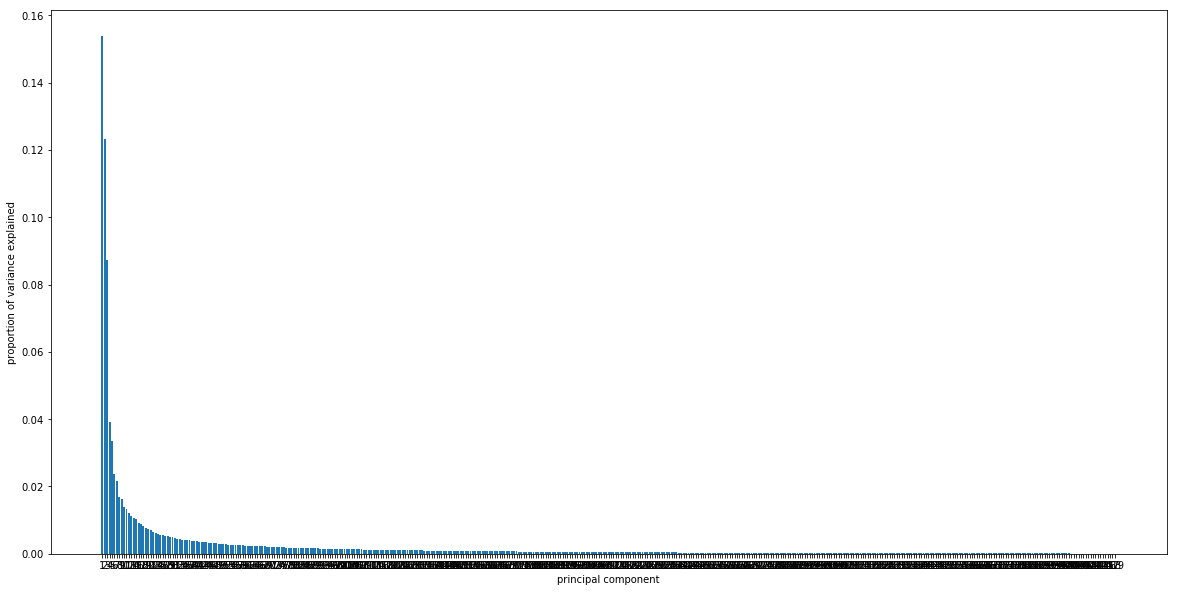

In [6]:
# Create bar plot
fig = plt.figure(figsize = (20,10))
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)



# Add labels
plt.xlabel('principal component')
plt.ylabel('proportion of variance explained')

plt.show()

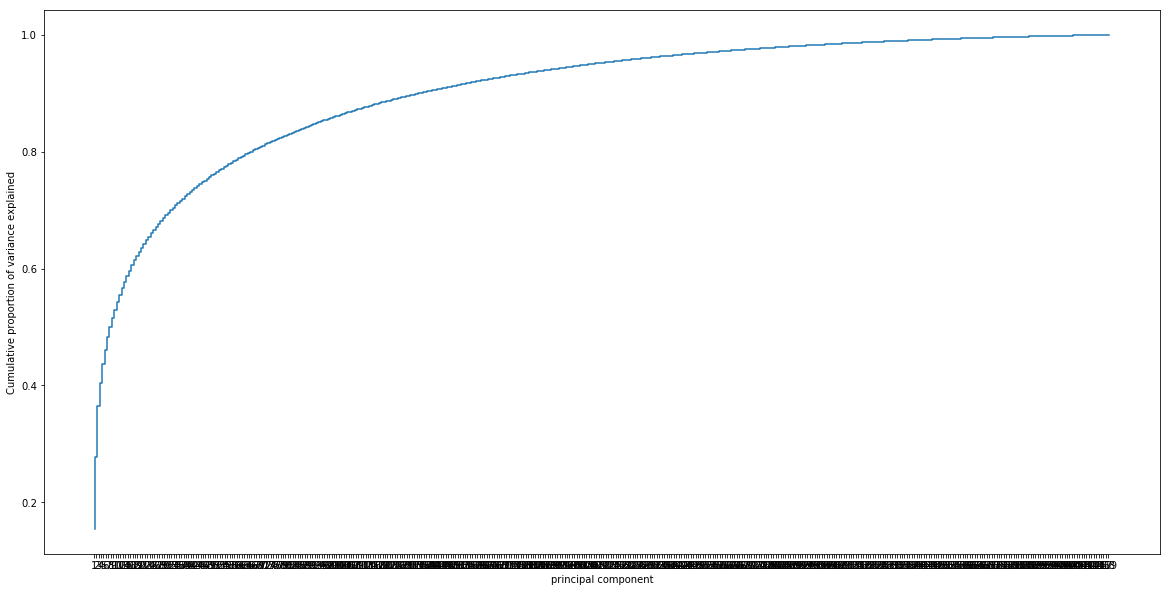

In [7]:
# Create bar plot
fig = plt.figure(figsize = (20,10))
xcor = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.xticks(xcor)
# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)
# Add labels
plt.xlabel('principal component')
plt.ylabel('Cumulative proportion of variance explained')
plt.show()

In [8]:
#explaining 80% of variance. 

print('70% of variance explained by {} components.'.format(np.sum(pve_cumsum<0.7)))
print('80% of variance explained by {} components.'.format(np.sum(pve_cumsum<0.8)))
print('90% of variance explained by {} components.'.format(np.sum(pve_cumsum<0.9)))

70% of variance explained by 33 components.
80% of variance explained by 66 components.
90% of variance explained by 135 components.


As seen on both plots above, all components (even the very first ones) explain a very low amount of variance in the dataset. The first component explains around 15% of variance. The second explains around 12% of variance, the third explains around 9% of variance and the fourth around 5%. 

According to this scree plot and the elbow method, the optimal number of components would be 10.

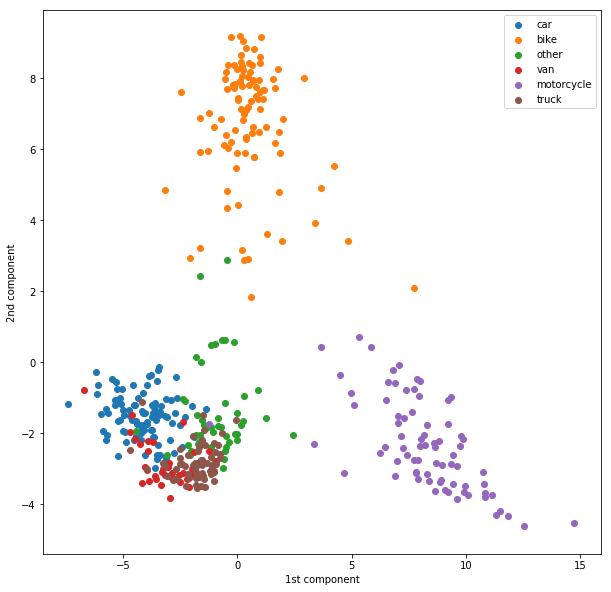

In [9]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#project data on the first two components
pca_2 = PCA(n_components=2)
pca_2.fit(X)
pca_2d = pca_2.transform(X)
fig = plt.figure(figsize = (10, 10))
for kind in pd.unique(y):
    # Wine samples of this type
    idx = (y == kind)

    # Plot their components
    plt.scatter(
        pca_2d[idx, 0], pca_2d[idx, 1],
        label='{}'.format(kind)
    )

# Labels and legend
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

As we can see on the figure above, the first two components allows us to separate some groups of images from the others. The first components allows us to separate motorcycles images from the other class, while the second component allows us to separate bike images from the other groups. Cars, trucks, vans and other vehicles are clustered together, with trucks and vans overlapping almost completely and other vehicles, being very scattered, having observations close to all groups. 